# Loading the data

## Download from kaggle

In [ ]:
import os
import shutil
import zipfile
import py7zr
from kaggle.api.kaggle_api_extended import KaggleApi

# Install necessary packages (works in Jupyter)
!pip install kaggle
!pip install py7zr

# Step 1: Move kaggle.json to the correct location
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)
kaggle_json_dest = os.path.join(kaggle_dir, "kaggle.json")

# Check if kaggle.json already exists to avoid errors
if not os.path.exists(kaggle_json_dest):
    shutil.move("kaggle.json", kaggle_json_dest)

# Set correct file permissions for kaggle.json
os.chmod(kaggle_json_dest, 0o600)

# Step 2: Authenticate with Kaggle API
api = KaggleApi()
api.authenticate()

# Step 3: Create a folder for the project data
project_data_folder = "../data/retail_kaggle_data/"
os.makedirs(project_data_folder, exist_ok=True)

# Step 4: Download dataset zip from the Kaggle competition
api.competition_download_files("favorita-grocery-sales-forecasting", path=project_data_folder)

# Step 5: Unzip the downloaded archive
zip_path = os.path.join(project_data_folder, "favorita-grocery-sales-forecasting.zip")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(project_data_folder)

# Step 6: Extract all .csv.7z files
for filename in os.listdir(project_data_folder):
    if filename.endswith(".csv.7z"):
        full_path = os.path.join(project_data_folder, filename)
        with py7zr.SevenZipFile(full_path, mode='r') as archive:
            archive.extractall(path=project_data_folder)

print("✅  Dataset downloaded and extracted successfully!")

'\n# Install necessary packages (works in Jupyter)\n!pip install kaggle\n!pip install py7zr\n\n# Step 1: Move kaggle.json to the correct location\nkaggle_dir = os.path.expanduser("~/.kaggle")\nos.makedirs(kaggle_dir, exist_ok=True)\nkaggle_json_dest = os.path.join(kaggle_dir, "kaggle.json")\n\n# Check if kaggle.json already exists to avoid errors\nif not os.path.exists(kaggle_json_dest):\n    shutil.move("kaggle.json", kaggle_json_dest)\n\n# Set correct file permissions for kaggle.json\nos.chmod(kaggle_json_dest, 0o600)\n\n# Step 2: Authenticate with Kaggle API\napi = KaggleApi()\napi.authenticate()\n\n# Step 3: Create a folder for the project data\nproject_data_folder = "./retail_kaggle_data/"\nos.makedirs(project_data_folder, exist_ok=True)\n\n# Step 4: Download dataset zip from the Kaggle competition\napi.competition_download_files("favorita-grocery-sales-forecasting", path=project_data_folder)\n\n# Step 5: Unzip the downloaded archive\nzip_path = os.path.join(project_data_folder, "

## Loading data into dataframes

In [3]:
import pandas as pd

folder_path = "retail_kaggle_data/"

df_stores = pd.read_csv(os.path.join(folder_path, 'stores.csv'))
df_items = pd.read_csv(os.path.join(folder_path, 'items.csv'))
df_transactions = pd.read_csv(os.path.join(folder_path, 'transactions.csv'))
df_oil = pd.read_csv(os.path.join(folder_path, 'oil.csv'))
df_holidays_events = pd.read_csv(os.path.join(folder_path, 'holidays_events.csv'))

# Optional: load only part of the training data for performance
df_train = pd.read_csv(os.path.join(folder_path, 'train.csv'))

print("✅ All datasets loaded successfully.")

/var/folders/sj/yq8_zfcj0vg1v9dyw7qpp8rm0000gn/T/ipykernel_67347/4091902328.py:12: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(os.path.join(folder_path, 'train.csv'))


✅ All datasets loaded successfully.


In [4]:
df_items.head(5)
# df_stores.head(5)
# df_transactions.head(5)
# df_oil.head(5)
# df_holidays_events.head(5)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


# Preprocessing

## Stores per Region

Let us get an overview of stores per region.

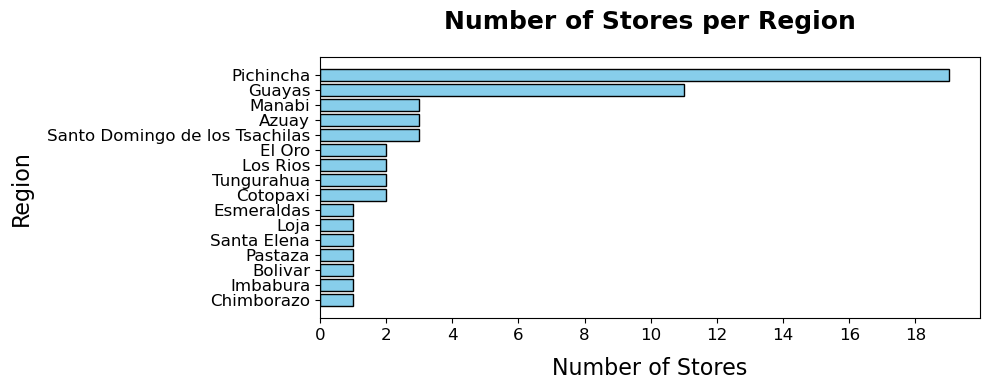

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

stores_per_region = df_stores['state'].value_counts().reset_index()
stores_per_region.columns = ['Region', 'Store Count']
stores_per_region = stores_per_region.sort_values(by='Store Count', ascending=True)

plt.figure(figsize=(10, 4))
plt.barh(stores_per_region['Region'], stores_per_region['Store Count'], color='skyblue', edgecolor='black')
plt.title("Number of Stores per Region", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Number of Stores", fontsize=16, labelpad=10)
plt.ylabel("Region", fontsize=16, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ensure integer x-ticks
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

Two regions have the most stores. For the project I will concentrate on the Guayas region.

In [6]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

To avoid complications because of the large size of train.csv I will load the train data in chunks.

In [7]:
# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv(folder_path + 'train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

/var/folders/sj/yq8_zfcj0vg1v9dyw7qpp8rm0000gn/T/ipykernel_67347/3523828238.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(folder_path + 'train.csv', chunksize=chunk_size):


In [8]:
shape_1 = df_train.shape[0]
print(df_train.shape)

(22941656, 6)


## Items Family

The dataset I am using is still very big even after filtering. Working with such big data can lead to crashes. To prevent further process from crashing, I will concentrate on certain item families.

In [9]:
df_train = df_train.merge(df_items[['item_nbr', 'family']], on='item_nbr', how='left')
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family
0,18789,2013-01-02,24,103665,6.0,NaN,BREAD/BAKERY
1,18790,2013-01-02,24,105574,12.0,NaN,GROCERY I
2,18791,2013-01-02,24,105575,2.0,NaN,GROCERY I
3,18792,2013-01-02,24,105577,1.0,NaN,GROCERY I
4,18793,2013-01-02,24,105693,7.0,NaN,GROCERY I


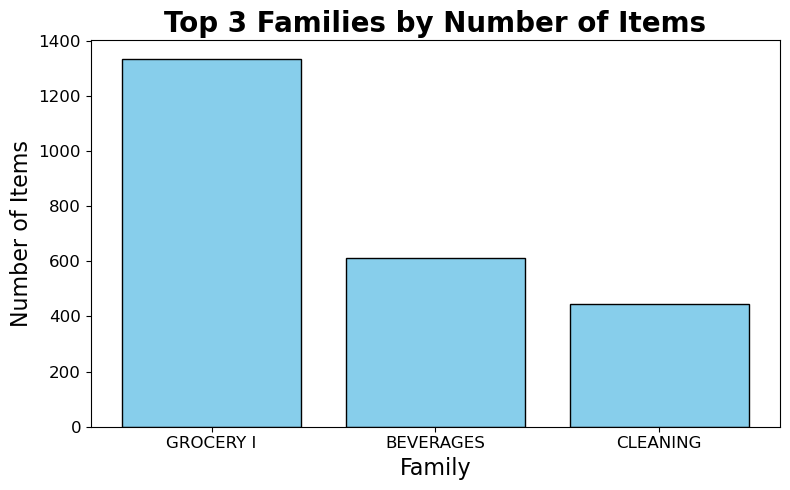

In [10]:
# Plotting the number of items per family (for top 3 families only)
# Compute the number of items per family and select the top 3 families

items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # Keep only the top 3 families

# Plot the top 3 families
plt.figure(figsize=(8, 5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 3 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

I only keep the top 3 families of items.

In [11]:
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

Lets check the shape again:

In [12]:
shape_2 = df_train.shape[0]
print(df_train.shape)

(14745768, 7)


In [13]:
reduction = ((1 - shape_2 / shape_1) * 100)
print(f"Reduction of dataset: {reduction:.2f}%")

Reduction of dataset: 35.72%


From about 23 million rows down to 14.7 millions. I trimmed down the dataset by about 36%.

## Missing values

In [14]:
# Checking missing values
df_train.isnull().sum()

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
family               0
dtype: int64

The onpromotion column has NaNs. I replace them with `False`

In [15]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

/var/folders/sj/yq8_zfcj0vg1v9dyw7qpp8rm0000gn/T/ipykernel_67347/2380528398.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


Outliers are next. Let's first work with the negative sales:

In [16]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

# Viewing negative sales for analysis
negative_sales.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family
18589,106658,2013-01-04,34,586824,-2.0,False,CLEANING
54236,309805,2013-01-09,35,1079215,-8.0,False,CLEANING
64452,382905,2013-01-11,27,1097187,-20.0,False,GROCERY I
96414,564108,2013-01-15,51,627885,-36.0,False,GROCERY I
132903,787522,2013-01-21,24,211205,-5.0,False,GROCERY I


Negative sales are replaced with 0s:

In [17]:
# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

Next, I am going to use a function for the z-score calculation to calculate the Z-score for each store-item.

In [18]:
# Function to compute Z-scores within each (store_nbr, item_nbr) group
def add_z_scores(group: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a 'z_score' column to the group based on 'unit_sales'.
    If std deviation is zero, uses 1 to avoid division by zero.
    """
    mean = group['unit_sales'].mean()
    std = group['unit_sales'].std() or 1  # Avoid division by zero
    group['z_score'] = (group['unit_sales'] - mean) / std
    return group

# Apply Z-score calculation to each store-item group
df_train = df_train.groupby(['store_nbr', 'item_nbr']).apply(add_z_scores).reset_index(drop=True)

/var/folders/sj/yq8_zfcj0vg1v9dyw7qpp8rm0000gn/T/ipykernel_67347/849718508.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby(['store_nbr', 'item_nbr']).apply(add_z_scores).reset_index(drop=True)


In the next step I will define a threshold for the Z-score to detect outliers:

In [19]:
# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train[df_train['z_score'] > 5]
outliers

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,z_score
188,15666702,2013-12-18,24,96995,14.0,False,GROCERY I,7.946399
286,59775862,2015-10-20,24,99197,14.0,False,GROCERY I,5.822016
289,60322807,2015-10-26,24,99197,19.0,False,GROCERY I,8.276173
721,15717753,2013-12-19,24,103520,27.0,False,GROCERY I,6.642670
770,18886543,2014-02-13,24,103520,22.0,False,GROCERY I,5.154400
...,...,...,...,...,...,...,...,...
14741488,114286905,2017-05-01,51,2048609,48.0,False,GROCERY I,7.830664
14742765,104195298,2017-01-25,51,2054291,21.0,False,BEVERAGES,6.141217
14743164,122354227,2017-07-16,51,2057033,21.0,True,BEVERAGES,5.247882
14743658,117045510,2017-05-27,51,2058907,12.0,False,BEVERAGES,5.054512


There are many of these values but they don't look like errors. These are just big sales.

## Date Column
Next, let's work with zero-sales that we might have for particular item-store combinations and for particualr dates:

In [20]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


I have a list of all dates between the min and max date in the dataset. Now I need to bring it all together:

In [21]:
# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')
all_combinations

,store_nbr,item_nbr,date
0,24,96995,2013-01-02
1,24,96995,2013-01-03
2,24,96995,2013-01-04
3,24,96995,2013-01-05
4,24,96995,2013-01-06
...,...,...,...
35069351,51,2127114,2017-08-11
35069352,51,2127114,2017-08-12
35069353,51,2127114,2017-08-13
35069354,51,2127114,2017-08-14


In [22]:
# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)
df_filled['onpromotion'] = df_filled['onpromotion'].fillna(False).astype(int)
df_filled = df_filled.drop(columns=['z_score'])

# Check the first few rows
print(df_filled.shape)
df_filled.head(5)

/var/folders/sj/yq8_zfcj0vg1v9dyw7qpp8rm0000gn/T/ipykernel_67347/176145186.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled['onpromotion'] = df_filled['onpromotion'].fillna(False).astype(int)


(35069356, 7)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,family
0,24,96995,2013-01-02,NaN,0.0,0,NaN
1,24,96995,2013-01-03,NaN,0.0,0,NaN
2,24,96995,2013-01-04,NaN,0.0,0,NaN
3,24,96995,2013-01-05,NaN,0.0,0,NaN
4,24,96995,2013-01-06,NaN,0.0,0,NaN


Now I have all dates and corresponding sales. I will replace the original dataframe.

In [23]:
df_train = df_filled
del df_filled

## Feature engineering

In [24]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

In [25]:
# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

In [26]:
print(df_train.shape)
df_train.head(10)

(35069356, 12)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,family,year,month,day,day_of_week,unit_sales_7d_avg
0,24,96995,2013-01-02,NaN,0.0,0,NaN,2013,1,2,2,NaN
1,24,96995,2013-01-03,NaN,0.0,0,NaN,2013,1,3,3,NaN
2,24,96995,2013-01-04,NaN,0.0,0,NaN,2013,1,4,4,NaN
3,24,96995,2013-01-05,NaN,0.0,0,NaN,2013,1,5,5,NaN
4,24,96995,2013-01-06,NaN,0.0,0,NaN,2013,1,6,6,NaN
5,24,96995,2013-01-07,NaN,0.0,0,NaN,2013,1,7,0,NaN
6,24,96995,2013-01-08,NaN,0.0,0,NaN,2013,1,8,1,0.000000
7,24,96995,2013-01-09,302230.0,2.0,0,GROCERY I,2013,1,9,2,0.285714
8,24,96995,2013-01-10,NaN,0.0,0,NaN,2013,1,10,3,0.285714
9,24,96995,2013-01-11,NaN,0.0,0,NaN,2013,1,11,4,0.285714


In [27]:
df_train.isna().sum()

store_nbr                   0
item_nbr                    0
date                        0
id                   20323588
unit_sales                  0
onpromotion                 0
family               20323588
year                        0
month                       0
day                         0
day_of_week                 0
unit_sales_7d_avg      124728
dtype: int64

In [28]:
# Step 1: Create a mapping from item_nbr to known family values (excluding NaNs)
item_family_map = df_train.dropna(subset=['family']).drop_duplicates(subset=['item_nbr'])[['item_nbr', 'family']]
item_family_dict = dict(zip(item_family_map['item_nbr'], item_family_map['family']))

# Step 2: Use the mapping to fill missing 'family' values based on 'item_nbr'
df_train['family'] = df_train['family'].fillna(df_train['item_nbr'].map(item_family_dict))

In [29]:
df_train.isna().sum()

store_nbr                   0
item_nbr                    0
date                        0
id                   20323588
unit_sales                  0
onpromotion                 0
family                      0
year                        0
month                       0
day                         0
day_of_week                 0
unit_sales_7d_avg      124728
dtype: int64

In [30]:
df_train.head(20)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,family,year,month,day,day_of_week,unit_sales_7d_avg
0,24,96995,2013-01-02,NaN,0.0,0,GROCERY I,2013,1,2,2,NaN
1,24,96995,2013-01-03,NaN,0.0,0,GROCERY I,2013,1,3,3,NaN
2,24,96995,2013-01-04,NaN,0.0,0,GROCERY I,2013,1,4,4,NaN
3,24,96995,2013-01-05,NaN,0.0,0,GROCERY I,2013,1,5,5,NaN
4,24,96995,2013-01-06,NaN,0.0,0,GROCERY I,2013,1,6,6,NaN
5,24,96995,2013-01-07,NaN,0.0,0,GROCERY I,2013,1,7,0,NaN
6,24,96995,2013-01-08,NaN,0.0,0,GROCERY I,2013,1,8,1,0.000000
7,24,96995,2013-01-09,302230.0,2.0,0,GROCERY I,2013,1,9,2,0.285714
8,24,96995,2013-01-10,NaN,0.0,0,GROCERY I,2013,1,10,3,0.285714
9,24,96995,2013-01-11,NaN,0.0,0,GROCERY I,2013,1,11,4,0.285714


## EDA

Data preprocessing and feature engineering is done. I will now perform EDA.
Lets start with total sale over time:

### Sales overview

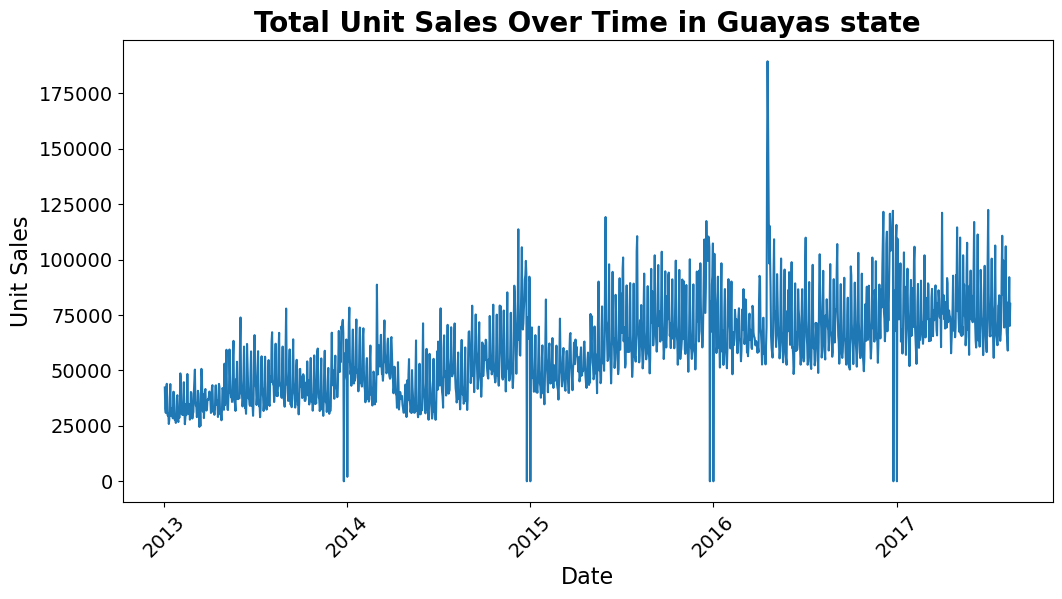

In [31]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

The total trend over time is positive. Notable fluctuations occur around the New Year period. Christmas shopping seems to be a high sales time. Maybe the negative peaks are a result of closing times between the years. There is also a very high peak in the first half of 2016.

Monthly sales are another interesting fact to check.

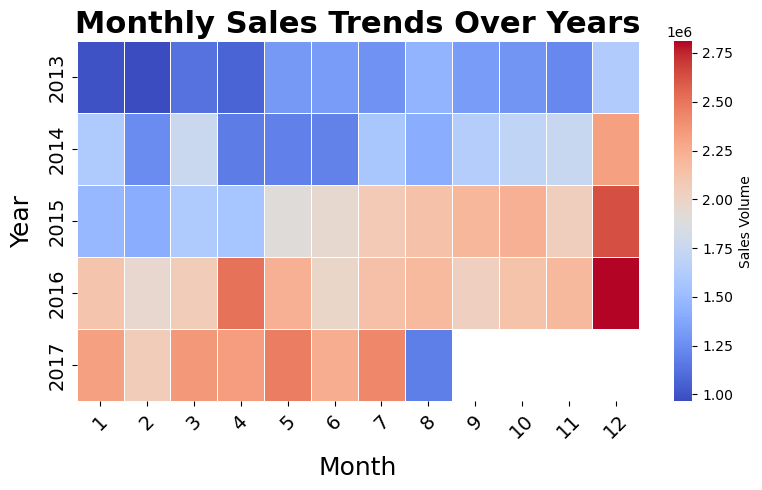

In [32]:
import seaborn as sns

# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Plotting heatmap of sales by year and month

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

The impact of holidays needs to be inspected.

In [33]:
# Convert date column to datetime
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print("Holidays range: from",df_holidays_events['date'].dt.date.min(),"till",df_holidays_events['date'].dt.date.max())

Holidays range: from 2012-03-02 till 2017-12-26


Days with zero sales will be excluded.

In [34]:
df_train_no_zero = df_train[df_train.unit_sales > 0]

In [35]:
# Merging df_train with zero sales with data with holidays
df_train_holiday = pd.merge(df_train_no_zero, df_holidays_events, on='date', how='left')

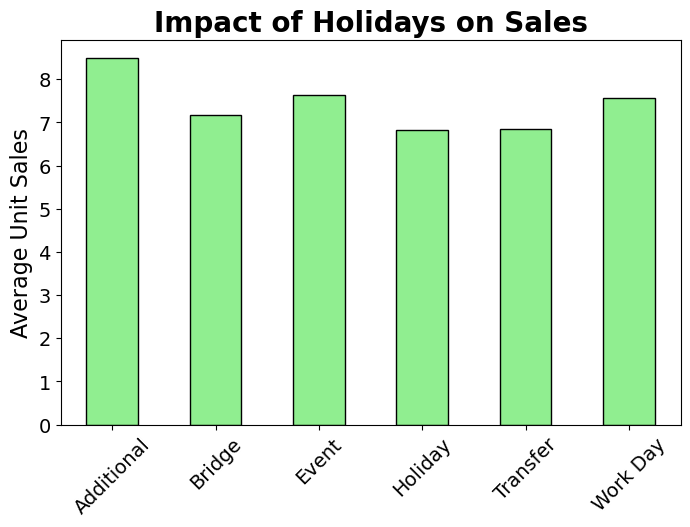

In [36]:
# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

## Final output for df_train

In [37]:
print(df_train.shape)
df_train.head()

(35069356, 12)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,family,year,month,day,day_of_week,unit_sales_7d_avg
0,24,96995,2013-01-02,NaN,0.0,0,GROCERY I,2013,1,2,2,NaN
1,24,96995,2013-01-03,NaN,0.0,0,GROCERY I,2013,1,3,3,NaN
2,24,96995,2013-01-04,NaN,0.0,0,GROCERY I,2013,1,4,4,NaN
3,24,96995,2013-01-05,NaN,0.0,0,GROCERY I,2013,1,5,5,NaN
4,24,96995,2013-01-06,NaN,0.0,0,GROCERY I,2013,1,6,6,NaN


For the project I only need dates until 2013-03-31. I will filter the data now.

In [38]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train[df_train['date'] < '2014-04-01']

The final dataset will be saved now:

In [ ]:
df_train.to_csv("./data/preprocessed/train_guayas_prepared.csv", index=False)

In [40]:
df_train.describe().T

,count,mean,min,25%,50%,75%,max,std
store_nbr,9437752.0,32.029151,24.0,27.0,30.0,35.0,51.0,7.403736
item_nbr,9437752.0,1154136.946267,96995.0,627263.0,1136208.5,1909409.0,2127114.0,618370.372093
date,9437752,2013-08-16 12:00:00,2013-01-02 00:00:00,2013-04-25 00:00:00,2013-08-16 12:00:00,2013-12-08 00:00:00,2014-03-31 00:00:00,NaN
id,2747275.0,10718844.819927,18790.0,5533892.0,10666113.0,15882970.0,21656543.0,6135138.247728
unit_sales,9437752.0,2.070799,0.0,0.0,0.0,1.0,2935.0,8.254941
onpromotion,9437752.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
year,9437752.0,2013.198238,2013.0,2013.0,2013.0,2013.0,2014.0,0.398672
month,9437752.0,5.640969,1.0,2.0,5.0,9.0,12.0,3.592233
day,9437752.0,15.715859,1.0,8.0,16.0,23.0,31.0,8.762449
day_of_week,9437752.0,3.004405,0.0,1.0,3.0,5.0,6.0,1.999995
